# Only the mathematical trading strategy for getting the signals

In [57]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Dataset

In [58]:
df_3m = pd.read_csv('datasets/btc_5m.csv')
df_3m['datetime'] = pd.to_datetime(df_3m['datetime'])
df_3m.set_index('datetime', inplace=True)
df_3m

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135
...,...,...,...,...,...
2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080
2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970
2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230


In [59]:
def filter_df(df, start_date, end_date):
    subset_df = df.loc[start_date:end_date]
    return subset_df

start_date = '2021-07-01'
end_date = '2022-12-01'
filtetred_df_3m = filter_df(df_3m, start_date, end_date)
print(filtetred_df_3m.shape)
filtetred_df_3m.iloc[[0,-1],:]

(61621, 5)


,open,high,low,close,volume
datetime,,,,,
2021-07-01 00:00:00,34613.41,34639.94,34559.67,34593.68,107.846895
2022-01-31 05:30:00,37881.75,37951.07,37869.98,37872.66,98.339090


In [60]:
def plot_candlestick_chart(df,num_candles=-1):
    if num_candles != -1:
        df = df.iloc[:num_candles]
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

    # Customize the layout
    fig.update_layout(title='Candlestick chart',
                    xaxis_title='Date and Time',
                    yaxis_title='Price data',
                    xaxis_rangeslider_visible=False)

    # Show the plot
    fig.show()

In [61]:
# plot_candlestick_chart(df_3m,num_candles=500)

## Strategy

### Adding the indicators

In [62]:
def add_indicators(df):
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14

    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [63]:
test_df = add_indicators(filtetred_df_3m)
print(test_df.shape)
test_df

(61608, 9)


C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\1214066279.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = 100 - (100 / (1 + rs))
C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\1214066279.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'] = exp_short - exp_long
C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\1214066279.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,open,high,low,close,volume,RSI,MACD,Signal_Line,ATR
datetime,,,,,,,,,
2021-07-01 01:05:00,34805.76,34814.28,34750.00,34758.19,179.126519,60.612316,41.992883,39.461753,94.937143
2021-07-01 01:10:00,34758.20,34845.00,34752.30,34832.72,174.553223,64.067465,46.097497,40.788901,95.825000
2021-07-01 01:15:00,34832.72,34841.92,34745.95,34754.99,245.773919,51.543444,42.587352,41.148591,91.326429
2021-07-01 01:20:00,34754.99,34775.00,34715.97,34746.65,285.424597,42.136468,38.686612,40.656196,81.252857
2021-07-01 01:25:00,34746.65,34759.16,34700.00,34743.56,282.240873,46.266864,34.943109,39.513578,75.984286
...,...,...,...,...,...,...,...,...,...
2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080,64.575746,93.365515,86.245029,124.137143
2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970,59.764810,81.529726,85.301968,128.064286
2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230,65.351837,73.849951,83.011565,127.711429


<Figure size 1400x600 with 0 Axes>

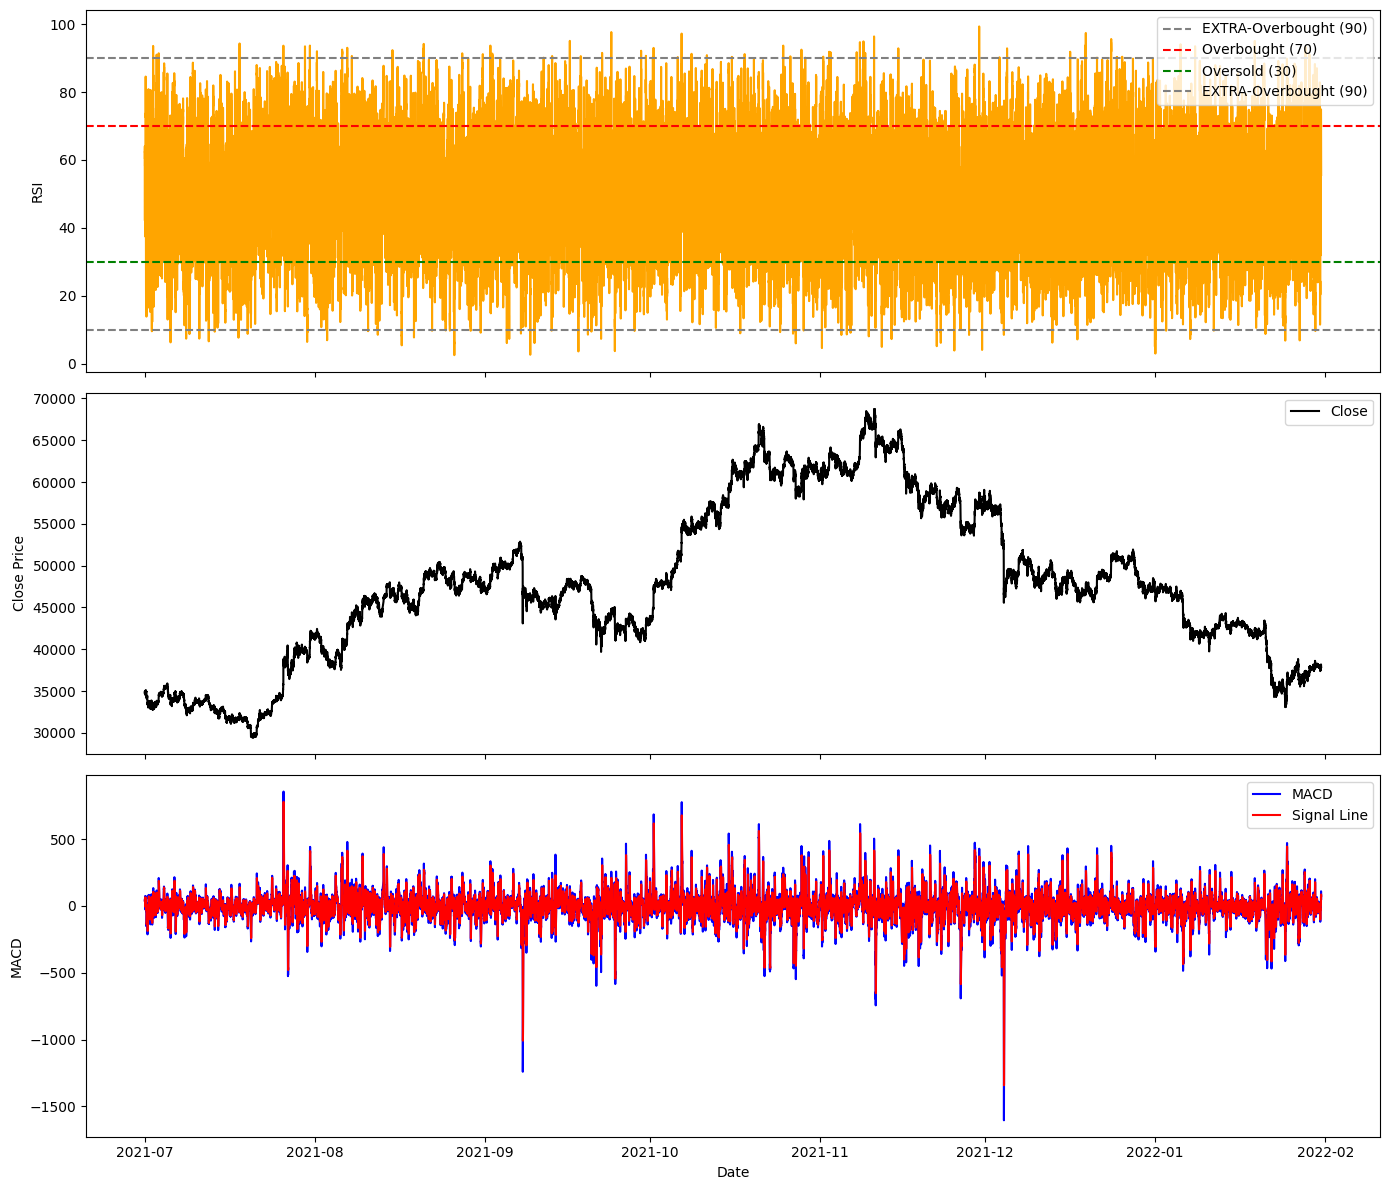

In [64]:
# For understanding the indicators

plot_df = test_df.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

In [65]:
# States
usd = 10000
btc = 0

# Define trading parameters
atr_factor = 1.5
take_profit_factor = 2
stop_loss = 0

# Initialize columns for signals and balances
test_df.loc[:,'Signal'] = ''
test_df.loc[:,'Balance_USD'] = 10000
test_df.loc[:,'Balance_BTC'] = 0

C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\2910862259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Signal'] = ''
C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\2910862259.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Balance_USD'] = 10000
C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\2910862259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [67]:
# Signals
def buy(usd, btc, current_close):
    if usd > 0 and btc == 0:
        btc = (usd  - (usd * 0.0015)) / current_close
        usd = 0
        return usd, btc, 'Buy'
    else:
        return usd, btc, "Holding"

def sell(usd, btc, current_close):
    if btc > 0 and usd == 0:
        usd = (btc - (btc * .0015)) * current_close
        btc = 0
        return usd, btc, 'Sell'
    else:
        return usd, btc, 'Waiting'

In [53]:
# Dataframe updation
def update_df(i,usd, btc, signal):
    test_df.at[test_df.index[i], 'Signal'] = signal
    test_df.at[test_df.index[i], 'Balance_USD'] = usd
    test_df.at[test_df.index[i], 'Balance_BTC'] = btc

In [54]:
from keras.models import load_model
model = load_model("models/BTC_LSTM_cp_1704897479.313657.h5")

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_test_df = scaler.fit_transform(np.array(test_df['close']).reshape(-1,1))

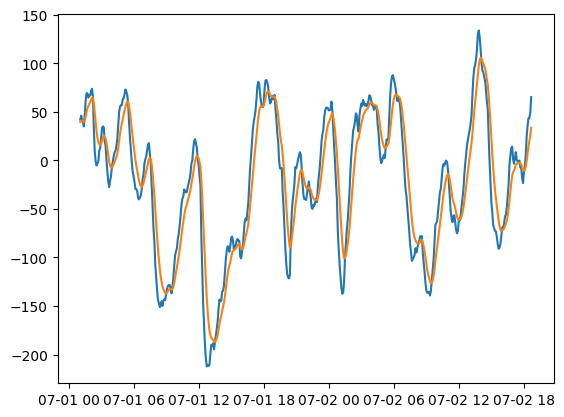

In [71]:
plt.plot(test_df['MACD'].iloc[:500])
plt.plot(test_df['Signal_Line'].iloc[:500])

In [56]:
# Trading loop
for i in range(14, len(test_df)):
    print(test_df.iloc[i])
    signal = ''
    current_row = test_df.iloc[i]
    previous_closes = scaled_test_df[i-13:i+1]
    scaled_previous_closes = previous_closes.reshape((1, previous_closes.shape[0], 1))
    predicted = model.predict(scaled_previous_closes,verbose=0)
    next_close = scaler.inverse_transform(predicted)[0][0]
    # print(next_close)
    if stop_loss != 0 and next_close < stop_loss:
        print("stop_loss will hit")
        usd, btc, signal = sell(usd, btc, current_row['close'])
        update_df(i, usd, btc, signal)
        continue

    indications = {
        "MACD-signal_line":0,
        # "RSI":0,
        # "candlestick":0,
    }

    # Check for general trend of the trade
    if current_row['MACD'] > current_row['Signal_Line']:
        indications['MACD-signal_line'] = 1 # Positive indication
    elif current_row['MACD'] < current_row['Signal_Line']:
        indications['MACD-signal_line'] = -1 # Negative indication
        # print(f"{i} MACD:{current_row['MACD']}\tSignal_Line:{current_row['Signal_Line']}")
    else:
        indications['MACD-signal_line'] = 0 # Neutral indication

    # Decide the signal
    vote = max(set(indications.values()), key=list(indications.values()).count)
    if vote == 1: # If enough things indicate upwards, if have sell, buy
        usd, btc, signal = buy(usd, btc, current_row['close'])
        stop_loss = current_row['close'] * (0.9785) # 1 - 0.02 - 0.0015
        update_df(i, usd, btc, signal)
        continue
    if vote == -1:# If enough things indicate downwards, and own btc, sell
        usd, btc, signal = sell(usd, btc, current_row['close'])
        stop_loss = 0
        update_df(i, usd, btc, signal)
        continue
    else: # Else just wait for the next turn
        signal = "Wait" if usd > 0  else "Hold"
        update_df(i, usd, btc, signal)
        continue
    # print(f"{vote}\t{signal}")
    # Update the progress
    # update_df(i, usd, btc, signal, indications)

test_df

open           34983.420000
high           34987.990000
low            34876.210000
close          34881.970000
volume           141.102456
RSI               57.228789
MACD              66.302681
Signal_Line       64.960095
ATR              108.766429
Name: 2021-07-01 02:15:00, dtype: float64


C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\2022941448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.at[test_df.index[i], 'Signal'] = signal
C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\2022941448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.at[test_df.index[i], 'Balance_USD'] = usd
C:\Users\sanya\AppData\Local\Temp\ipykernel_9440\2022941448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

open             34884.95
high             34907.34
low              34391.43
close            34554.98
volume         971.179207
RSI             37.473616
MACD            33.632667
Signal_Line     58.694609
ATR            138.995714
Signal                nan
Balance_USD           NaN
Balance_BTC           NaN
Name: 2021-07-01 02:20:00, dtype: object
open             34553.18
high             34632.04
low              34509.18
close             34580.4
volume         235.438994
RSI             41.735854
MACD              9.68103
Signal_Line     48.891893
ATR            140.916429
Signal                nan
Balance_USD           NaN
Balance_BTC           NaN
Name: 2021-07-01 02:25:00, dtype: object
open              34580.4
high              34735.2
low               34580.0
close            34684.69
volume         212.216318
RSI             47.311371
MACD            -0.875392
Signal_Line     38.938436
ATR            147.785714
Signal                nan
Balance_USD           NaN
Balance_

KeyboardInterrupt: 

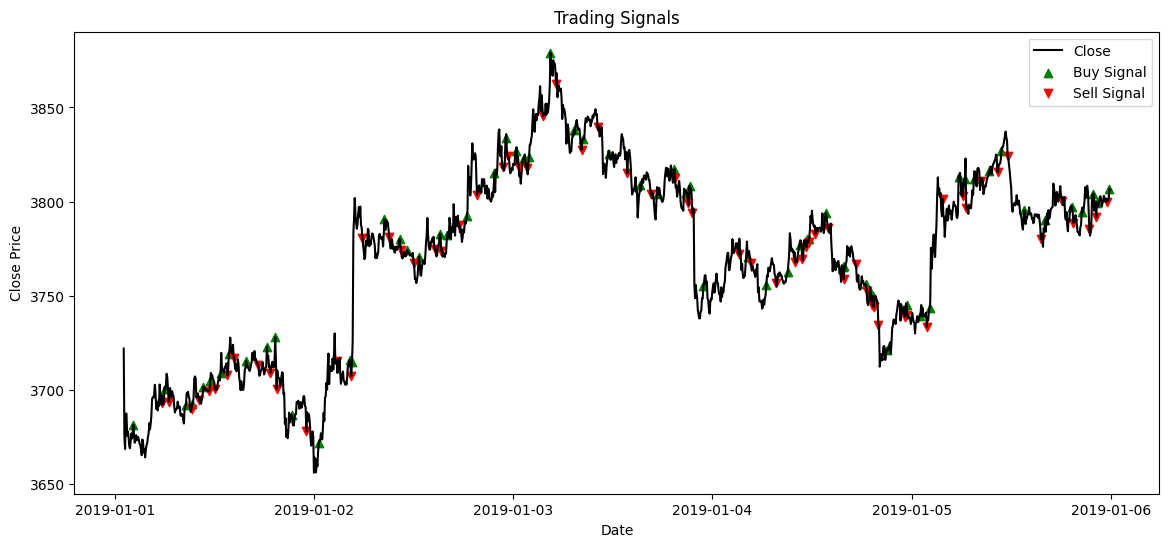

In [ ]:
plot_df = test_df.iloc[:,:]
plt.figure(figsize=(14, 6))

# Plot close values
plt.plot(plot_df.index, plot_df['close'], label='Close', color='black')
# plt.plot(plot_df['SMA_14'],label="14 previous average")
# plt.plot(plot_df['SMA_20'],label="20 previous average")
# plt.plot(plot_df['SMA_50'],label="50 previous average")


# Marking Buy signals with green upward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Buy'].index, plot_df[plot_df['Signal'] == 'Buy']['close'], label='Buy Signal', marker='^', color='g', alpha=1)

# Marking Sell signals with red downward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Sell'].index, plot_df[plot_df['Signal'] == 'Sell']['close'], label='Sell Signal', marker='v', color='r', alpha=1)

# Marking Wait signals with blue circles
# plt.scatter(plot_df[plot_df['Signal'] == 'Wait'].index, plot_df[plot_df['Signal'] == 'Wait']['close'], label='Wait Signal', marker='o', color='b', alpha=0.5)

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# plot_candlestick_chart(plot_df)